# **<center> Введение в Python, New Economic School, MAE 2022 </center>**
## **<center> Занятие 7 </center>**

**План**:

* **Обычные регрессии**: МНК, Взвешенный МНК, Обобщенный МНК, Доступный обобщенный МНК
* **Тестирование гипотез**: одиночные гипотезы, совместные гипотезы, гипотезы о гетероскедастичности, тесты на мультиколлинеарность (VIF)
* **Инструментальные переменные**: (TSLS)
* **Панельные данные**: Fixed Effects, Random Effects, First Differences
* **Модели с дискретной зависимой переменной**: Logit, Probit
* **Временные ряды**
  * автокорреляционная функция
  * частная автокорреляционная функция
  * тестирование стационарности
  * **Модели временных рядов**: AR(X), MA(X), ARMA(X), ARIMA(X), SARIMA(X), ARCH, GARCH
* **Остальные модели**: Квантильная регрессия, Ядерная регрессия, GLM (generalized linear models)




Подгрузим все, что нам требуется

In [ ]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.api import add_constant, tsa

import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Common regressions

Начнем разбор с обычных регрессий - в частности, МНК, взвешенный МНК, обобщенный МНК и доступный (обобщенный) МНК. 

Для оценки моделей, подгрузим данные по ценам проданных домов в Бостоне.

Добавим дополнительно переменную возраста (в годах) дома на момент продажи

In [ ]:
df = pd.read_csv('/content/Boston_House_Prices.csv')

df['AGE'] = df['YrSold'] - df['YearBuilt']
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,AGE
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,5
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,31
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,7
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,91
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,8


Убедимся, что у возраста минимальное значение больше или равно нулю (проверка на случай ошибок в данных)

In [ ]:
df['AGE'].min()

0

### OLS

Из **sm**, который мы ипортировали как **statsmodels.api**, возьмем метод `OLS`

В него надо передать эндогенную переменную (ваш Y) и экзогенные переменные (ваши X). По дефолту, константа не включается. Поэтому нужно добавить ее с помощью `add_constant(your_date)`.

Метод `.fit()` обучает Вашу модель.

С помощью `.summary()` или `.summary2()` Вы можете вывести информацию по оцененной регрессии.

Внутри этих методов Вы можете указать уровень значимости (для доверительных интервалов) , название регрессии и названия переменных.

С помощью библиотеки **stargazer**, либо встроенными методами, Вы можете перевести результирующие таблички в *.tex* формат. Для этого смотрите предыдущие семинары.

In [ ]:
endog = df['SalePrice']
exog = add_constant(df['GrLivArea'])

ols_reg = sm.OLS(endog = endog, exog = exog).fit()
print(ols_reg.summary2(alpha = 0.05, title = 'Обычный МНК', yname = 'Цена продажи', xname = ['Константа', 'Жилая площадь']))

                             Обычный МНК
Model:               OLS               Adj. R-squared:      0.502     
Dependent Variable:  Цена продажи      AIC:                 36073.7610
Date:                2021-04-03 17:22  BIC:                 36084.3334
No. Observations:    1460              Log-Likelihood:      -18035.   
Df Model:            1                 F-statistic:         1471.     
Df Residuals:        1458              Prob (F-statistic):  4.52e-223 
R-squared:           0.502             Scale:               3.1442e+09
----------------------------------------------------------------------
                Coef.     Std.Err.    t    P>|t|    [0.025    0.975]  
----------------------------------------------------------------------
Константа     18569.0259 4480.7545  4.1442 0.0000 9779.6119 27358.4399
Жилая площадь   107.1304    2.7936 38.3482 0.0000  101.6504   112.6103
----------------------------------------------------------------------
Omnibus:              261.166       

Из **smf**, который мы ипортировали как **statsmodels.formula.api**, возьмем метод `ols()`. **statsmodels.formula.api** позволяет передавать формулу спецификации (в формате *patsy*) напрямую (дополнительно нужно передать данные). 

In [ ]:
specification = 'SalePrice ~ GrLivArea'

ols_reg = smf.ols(specification, df).fit()
print(ols_reg.summary2())

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.502     
Dependent Variable: SalePrice        AIC:                36073.7610
Date:               2021-04-03 17:22 BIC:                36084.3334
No. Observations:   1460             Log-Likelihood:     -18035.   
Df Model:           1                F-statistic:        1471.     
Df Residuals:       1458             Prob (F-statistic): 4.52e-223 
R-squared:          0.502            Scale:              3.1442e+09
-------------------------------------------------------------------
             Coef.     Std.Err.    t    P>|t|    [0.025    0.975]  
-------------------------------------------------------------------
Intercept  18569.0259 4480.7545  4.1442 0.0000 9779.6119 27358.4399
GrLivArea    107.1304    2.7936 38.3482 0.0000  101.6504   112.6103
-------------------------------------------------------------------
Omnibus:             261.166       Durbin-Watson:          2.025  

Внутри формулы можно применять функции к переменным, как в примере ниже

In [ ]:
specification = 'np.log(SalePrice) ~ np.log(GrLivArea)'

ols_reg = smf.ols(specification, df).fit()
print(ols_reg.summary2())

                  Results: Ordinary least squares
Model:              OLS               Adj. R-squared:     0.533    
Dependent Variable: np.log(SalePrice) AIC:                354.1941 
Date:               2021-04-03 17:22  BIC:                364.7664 
No. Observations:   1460              Log-Likelihood:     -175.10  
Df Model:           1                 F-statistic:        1666.    
Df Residuals:       1458              Prob (F-statistic): 1.60e-243
R-squared:          0.533             Scale:              0.074523 
--------------------------------------------------------------------
                   Coef.   Std.Err.     t     P>|t|   [0.025  0.975]
--------------------------------------------------------------------
Intercept          5.6681    0.1559  36.3601  0.0000  5.3623  5.9739
np.log(GrLivArea)  0.8745    0.0214  40.8151  0.0000  0.8325  0.9166
-------------------------------------------------------------------
Omnibus:              111.954       Durbin-Watson:          2

Также можно добавлять дамми-переменные через `C(your_variable)`. Если бы работали без формулы, пришлось бы еще побить переменную на дамми. Ниже даны два варианта - с формулой и без

Более того, если нужно сделать прогноз - не требуется создавать преобразованные переменные в случае использования формулы.

In [ ]:
specification = 'np.log(SalePrice) ~ np.log(GrLivArea) + C(Fireplaces)'

ols_reg = smf.ols(specification, df).fit()
print(ols_reg.summary2())

                  Results: Ordinary least squares
Model:              OLS               Adj. R-squared:     0.568    
Dependent Variable: np.log(SalePrice) AIC:                242.9470 
Date:               2021-04-03 17:22  BIC:                269.3780 
No. Observations:   1460              Log-Likelihood:     -116.47  
Df Model:           4                 F-statistic:        480.8    
Df Residuals:       1455              Prob (F-statistic): 3.09e-264
R-squared:          0.569             Scale:              0.068914 
-------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-------------------------------------------------------------------
Intercept             6.4465   0.1675 38.4772 0.0000  6.1178 6.7751
C(Fireplaces)[T.1]    0.1673   0.0160 10.4813 0.0000  0.1360 0.1987
C(Fireplaces)[T.2]    0.1918   0.0281  6.8374 0.0000  0.1368 0.2468
C(Fireplaces)[T.3]    0.0103   0.1191  0.0868 0.9308 -0.2233 0.244

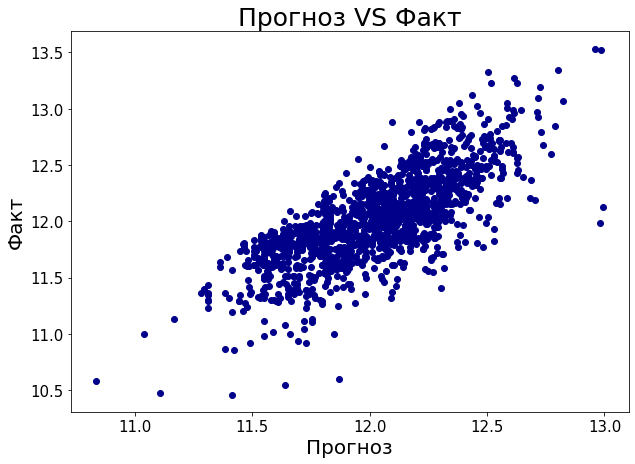

In [ ]:
prediction = ols_reg.predict(df)

plt.figure(figsize = (10, 7))
plt.scatter(prediction, df['SalePrice'].apply(np.log), color = 'darkblue')
plt.tick_params(labelsize = 15)
plt.title('Прогноз VS Факт', fontsize = 25)
plt.xlabel('Прогноз', fontsize = 20)
plt.ylabel('Факт', fontsize = 20)
plt.show()

In [ ]:
endog = df['SalePrice'].apply(np.log)
exog = df[['GrLivArea', 'Fireplaces']]
exog['GrLivArea'] = np.log(exog['GrLivArea'] + 1)

exog = exog.join(pd.get_dummies(exog['Fireplaces'], prefix = 'Fireplaces QNT', drop_first = True))
exog = exog.drop(columns = 'Fireplaces')
exog = add_constant(exog)

ols_reg = sm.OLS(endog = endog, exog = exog).fit()
print(ols_reg.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.568    
Dependent Variable: SalePrice        AIC:                242.9508 
Date:               2021-04-03 17:22 BIC:                269.3818 
No. Observations:   1460             Log-Likelihood:     -116.48  
Df Model:           4                F-statistic:        480.8    
Df Residuals:       1455             Prob (F-statistic): 3.09e-264
R-squared:          0.569            Scale:              0.068914 
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
const                6.4418   0.1677 38.4162 0.0000  6.1129 6.7708
GrLivArea            0.7557   0.0236 32.0637 0.0000  0.7094 0.8019
Fireplaces QNT_1     0.1673   0.0160 10.4815 0.0000  0.1360 0.1987
Fireplaces QNT_2     0.1918   0.0281  6.8369 0.0000  0.1368 0.2468
Fireplaces QN

In [ ]:
prediction = ols_reg.predict(df)

ValueError: ignored

Не можем сделать прогноз - в данных нет наших преобразованных переменных. Потребуется создать переменные в таблице df или же использовать exog, в котором уже хранятся преобразованные данные

In [ ]:
prediction = ols_reg.predict(exog)

Также в методе `.fit()` можно указывать тип ковариационной матрицы. Вместо обычных стандартных ошибок коэффициентов, можно взять робастные ошибки в форме Уайта (HC0 и разработанные впоследствие HC1, HC2, и HC3)

\begin{equation} Var(\hat{\beta}) = (X'X)^{-1}X' \Phi X (X'X)^{-1} \end{equation}

\begin{equation} \mathbb{E}[\epsilon] = 0, \ \mathbb{E}[\epsilon \epsilon']= \Phi \end{equation}

При гомоскедастичности ошибок $\Phi = \sigma^2 I$

\begin{equation} Var(\hat{\beta}) \sigma^2 I (X'X)^{-1} \end{equation}

где $ \hat{\sigma}^2 = \frac{\sum_{i = 1}^N e_i}{N - K} $

Т.к. часто функциональная форма гетероскедастичности неизвестна, мы не можем напрямую использовать первое уравнение. 

В HC0 в качестве $\Phi$ используется оценка с помощью остатков модели, $e_i$, так что $\hat{\Phi} = diag(e_i) $, и

\begin{equation} HC_0(\hat{\beta}) = (X'X)^{-1}X' diag(e_i) X (X'X)^{-1} = 
(X'X)^{-1} \sum_{i=1}^N (e_i^2 x_i x_i') (X'X)^{-1}  \end{equation}

\begin{equation} HC_1 = \frac{N}{N - K} HC_0 \end{equation}

\begin{equation} HC_2 =  (X'X)^{-1}X' diag[\frac{e_i^2}{1-h_{ii}}] X (X'X)^{-1} \end{equation}

где $h_{ii} = x_i (X'X)^{-1} x_i'$

\begin{equation} HC_3 =  (X'X)^{-1}X' diag[\frac{e_i^2}{(1-h_{ii})^2}] X (X'X)^{-1} \end{equation}

Все оценки являются ассимптотически эквивалентными. Однако на малых выборках в литературе предпочтение отдается HC3.

In [ ]:
specification = 'np.log(SalePrice) ~ np.log(GrLivArea) + C(Fireplaces) + np.log(AGE + 1)'

ols_reg = smf.ols(specification, df).fit(cov_type = 'HC1')
print(ols_reg.summary2())

                  Results: Ordinary least squares
Model:              OLS               Adj. R-squared:     0.733    
Dependent Variable: np.log(SalePrice) AIC:                -458.2476
Date:               2021-04-03 17:51  BIC:                -426.5305
No. Observations:   1460              Log-Likelihood:     235.12   
Df Model:           5                 F-statistic:        532.0    
Df Residuals:       1454              Prob (F-statistic): 0.00     
R-squared:          0.734             Scale:              0.042602 
-------------------------------------------------------------------
                    Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept           7.9239   0.1731  45.7723 0.0000  7.5846  8.2632
C(Fireplaces)[T.1]  0.1259   0.0119  10.5824 0.0000  0.1025  0.1492
C(Fireplaces)[T.2]  0.2727   0.0234  11.6560 0.0000  0.2269  0.3186
C(Fireplaces)[T.3]  0.0196   0.2752   0.0714 0.9431 -0.5196  0.558

### WLS

Также в `statsmodels` доступен взвешенный метод наименьших квадратов. Вызвать его можно через метод `WLS()` из **statsmodels.api** или через метод `wls()` из **statsmodels.formula.api**

\begin{equation} \hat{\beta} = argmin_{b} \sum_{i=1}^N w_i (y - \sum_{j = 1}^K x_ij b_j)^2 = argmin_b || W^{\frac{1}{2}} (y - Xb) ||^2 \end{equation}

Передавая веса в аргумент `weights`, $w_i = \sqrt{your\_weights_i}$

In [ ]:
specification = 'np.log(SalePrice) ~ np.log(GrLivArea) + C(Fireplaces)'

wls_no_weights = smf.wls(specification, df, weights = 1).fit(cov_type = 'HC1')
print(wls_no_weights.summary2())

                  Results: Weighted least squares
Model:              WLS               Adj. R-squared:     0.568    
Dependent Variable: np.log(SalePrice) AIC:                242.9470 
Date:               2021-04-03 18:08  BIC:                269.3780 
No. Observations:   1460              Log-Likelihood:     -116.47  
Df Model:           4                 F-statistic:        399.7    
Df Residuals:       1455              Prob (F-statistic): 2.12e-232
R-squared:          0.569             Scale:              0.068914 
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------
Intercept             6.4465   0.1918 33.6168 0.0000  6.0706 6.8223
C(Fireplaces)[T.1]    0.1673   0.0162 10.3529 0.0000  0.1357 0.1990
C(Fireplaces)[T.2]    0.1918   0.0287  6.6907 0.0000  0.1356 0.2480
C(Fireplaces)[T.3]    0.0103   0.2419  0.0428 0.9659 -0.4638 0.484

Передадим возраста дома на момент продажи в качестве веса (функция потерь будет домножена на корень).

Единицу прибавили, чтобы избежать деления на 0

In [ ]:
specification = 'np.log(SalePrice) ~ np.log(GrLivArea) + C(Fireplaces)'

wls_with_weights = smf.wls(specification, df, weights = 1 / (df['AGE'] + 1)).fit(cov_type = 'HC1')
print(wls_with_weights.summary2())

                  Results: Weighted least squares
Model:              WLS               Adj. R-squared:     0.539    
Dependent Variable: np.log(SalePrice) AIC:                1517.4372
Date:               2021-04-03 18:09  BIC:                1543.8681
No. Observations:   1460              Log-Likelihood:     -753.72  
Df Model:           4                 F-statistic:        64.69    
Df Residuals:       1455              Prob (F-statistic): 2.15e-50 
R-squared:          0.540             Scale:              0.0078127
-------------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------
Intercept            6.3070   0.7566  8.3361 0.0000  4.8241  7.7898
C(Fireplaces)[T.1]   0.1463   0.0280  5.2321 0.0000  0.0915  0.2012
C(Fireplaces)[T.2]   0.2495   0.0720  3.4653 0.0005  0.1084  0.3906
C(Fireplaces)[T.3]  -0.8788   0.4067 -2.1605 0.0307 -1.6760 -0.081

### GLS and Feasible GLS

\begin{equation} \hat{\beta} = (X'\Omega^{-1} X)^{-1} X' \Omega y \end{equation}

\begin{equation} Var(\hat{\beta}) = (X'\Omega^{-1} X)^{-1}  \end{equation}

К сожалению, доступный метод наименьших квадратов в Python не такой уж и доступный. Поэтому требуется реализовать его своими руками.

Однако в случае GLS, который реализован, мы должны задать ковариационную матрицу $\Omega$ и передать в параметр `sigma`, как в примере ниже.




In [ ]:
specification = 'np.log(SalePrice) ~ np.log(GrLivArea) + C(Fireplaces)'

sigma = np.eye(1460)
sigma[0][0] = 10
sigma[1][1] = 5

gls_reg = smf.gls(specification, df, sigma = sigma).fit(cov_type = 'HC1')
print(gls_reg.summary2())

                Results: Generalized least squares
Model:              GLS               Adj. R-squared:     0.568    
Dependent Variable: np.log(SalePrice) AIC:                246.3088 
Date:               2021-04-03 19:03  BIC:                272.7397 
No. Observations:   1460              Log-Likelihood:     -118.15  
Df Model:           4                 F-statistic:        399.7    
Df Residuals:       1455              Prob (F-statistic): 2.22e-232
R-squared:          0.569             Scale:              0.068888 
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------
Intercept             6.4482   0.1919 33.5948 0.0000  6.0720 6.8244
C(Fireplaces)[T.1]    0.1675   0.0162 10.3455 0.0000  0.1358 0.1993
C(Fireplaces)[T.2]    0.1921   0.0287  6.6997 0.0000  0.1359 0.2484
C(Fireplaces)[T.3]    0.0108   0.2419  0.0446 0.9644 -0.4633 0.48

Дальше я подразумеваю отсутствие автокорреляции в данных и делаю оценку FGLS самым простым образом - взвешиваю на обратны квадрат остатков из обычног МНК.

Можно также взять остатки из обычного МНК (взять от них логарифм, квадрат, модуль или прочие преобразования) и срегрессировать на Ваши (все/выборочно) ковариаты. Обратные значения оцеок остатков этой модели взять в качестве весов.

In [ ]:
specification = 'np.log(SalePrice) ~ np.log(GrLivArea) + C(Fireplaces)'

ols_reg = smf.ols(specification, df).fit(cov_type = 'HC1')
print(ols_reg.summary2())

ols_resids = ols_reg.resid

                  Results: Ordinary least squares
Model:              OLS               Adj. R-squared:     0.568    
Dependent Variable: np.log(SalePrice) AIC:                242.9470 
Date:               2021-04-03 19:03  BIC:                269.3780 
No. Observations:   1460              Log-Likelihood:     -116.47  
Df Model:           4                 F-statistic:        399.7    
Df Residuals:       1455              Prob (F-statistic): 2.12e-232
R-squared:          0.569             Scale:              0.068914 
-------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------
Intercept             6.4465   0.1918 33.6168 0.0000  6.0706 6.8223
C(Fireplaces)[T.1]    0.1673   0.0162 10.3529 0.0000  0.1357 0.1990
C(Fireplaces)[T.2]    0.1918   0.0287  6.6907 0.0000  0.1356 0.2480
C(Fireplaces)[T.3]    0.0103   0.2419  0.0428 0.9659 -0.4638 0.484

In [ ]:
specification = 'np.log(SalePrice) ~ np.log(GrLivArea) + C(Fireplaces)'

fgls_reg = smf.wls(specification, df, weights = 1 / (ols_resids ** 2)).fit(cov_type = 'HC1')
print(fgls_reg.summary2())

                  Results: Weighted least squares
Model:              WLS               Adj. R-squared:     1.000     
Dependent Variable: np.log(SalePrice) AIC:                -1755.1691
Date:               2021-04-03 19:03  BIC:                -1728.7381
No. Observations:   1460              Log-Likelihood:     882.58    
Df Model:           4                 F-statistic:        1.738e+06 
Df Residuals:       1455              Prob (F-statistic): 0.00      
R-squared:          1.000             Scale:              0.99676   
--------------------------------------------------------------------
                      Coef.  Std.Err.     z     P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept             6.4362   0.0028 2267.9380 0.0000 6.4306 6.4418
C(Fireplaces)[T.1]    0.1668   0.0005  356.7963 0.0000 0.1659 0.1677
C(Fireplaces)[T.2]    0.1893   0.0008  236.8463 0.0000 0.1878 0.1909
C(Fireplaces)[T.3]    0.0219   0.0028    7.9097 0.000

Коэффициенты поменялись немного, что довольно логично, т.к. гетероскедастичность не влияет на состоятельность и несмещенность. Стандартные ошибки параметров модели стали меньше. Также значения F-статистики, как и $R^2$ улетели в небеса (тут стоит отметить скорее всего в расчет этих значений закралась ошибка - поэтому всегда можно пересчитать значения)

In [ ]:
from sklearn.metrics import r2_score # с sklearn вы познакомитесь очень хорошо на курсе машинного обучения Евгения Соколова

r2_score(df['SalePrice'].apply(np.log), fgls_reg.fittedvalues)

0.5692807687542311

## Hypothesis Testing

Также очень часто возникает потребность в тестировании различных гипотез и отладке модели.

С помощью т-теста Стьюдента можно тестировать одиночные гипотезы по модели. Вызвать его можно от натренированной модели с помощью метода `.t_test()`, передав нулевую гипотезу внутрь (patsy "синтаксис")

In [ ]:
specification = 'np.log(SalePrice + 1) ~ np.log(GrLivArea + 1) + np.log(AGE + 1)'

ols_reg = smf.ols(specification, df).fit(cov_type = 'HC3')
print(ols_reg.summary2())

                    Results: Ordinary least squares
Model:              OLS                   Adj. R-squared:     0.699    
Dependent Variable: np.log(SalePrice + 1) AIC:                -285.9254
Date:               2021-04-03 19:22      BIC:                -270.0669
No. Observations:   1460                  Log-Likelihood:     145.96   
Df Model:           2                     F-statistic:        893.3    
Df Residuals:       1457                  Prob (F-statistic): 6.18e-254
R-squared:          0.699                 Scale:              0.048038 
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               7.1642   0.1815  39.4749 0.0000  6.8085  7.5199
np.log(GrLivArea + 1)   0.7230   0.0247  29.2800 0.0000  0.6746  0.7714
np.log(AGE + 1)        -0.1295   0.0051 -25.2300 0.0000 -0.1396 -0.1194
------------

In [ ]:
test_1 = ols_reg.t_test("np.log(GrLivArea + 1) = 0")
test_2 = ols_reg.t_test("np.log(GrLivArea + 1) = 0.7230")

test_3 = ols_reg.t_test("np.log(GrLivArea + 1) = np.log(AGE + 1)")

print(test_1)
print('\n')
print(test_2)
print('\n')
print(test_3)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.7230      0.025     29.280      0.000       0.675       0.771


                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.7230      0.025     -0.002      0.999       0.675       0.771


                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.8525      0.024     34.973      0.000       0.805       0.900


Для тестирования совместных гипотез можно использовать F-тест и тест Вальда с помощью `f_test()` и `wald_test()`

In [ ]:
hyp_1 = "(np.log(GrLivArea + 1) = np.log(AGE + 1) = 1), (Intercept = 2)"
print(ols_reg.f_test(hyp_1))

<F test: F=array([[16958.61892173]]), p=0.0, df_denom=1.46e+03, df_num=3>


In [ ]:
hyp_2 = '(Intercept = np.log(AGE + 1) = 2)'
print(ols_reg.wald_test(hyp_2))

<Wald test (chi2): statistic=[[177975.33879801]], p-value=0.0, df_denom=2>


In [ ]:
hyp_3 = '(Intercept = 7), (np.log(AGE + 1) = -0.13)'
print(ols_reg.wald_test(hyp_3))

<Wald test (chi2): statistic=[[0.92777706]], p-value=0.6288336472767825, df_denom=2>


In [ ]:
hyp_3 = '(Intercept = 7), (np.log(AGE + 1) = -0.13)'
print(ols_reg.wald_test(hyp_3, use_f = True))

<F test: F=array([[0.46388853]]), p=0.6289264907180601, df_denom=1.46e+03, df_num=2>


In [ ]:
print(ols_reg.wald_test('np.log(GrLivArea + 1) = 0.7230, np.log(AGE + 1) = 0'))

<Wald test (chi2): statistic=[[654.39297939]], p-value=7.950053077688992e-143, df_denom=2>


Также иногда может потребоваться протестировать модель на пристутсвие гетероскедастичности. Для этого можно пользоваться одним из приведенных 3 тестов - тестом [Уайта](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%A3%D0%B0%D0%B9%D1%82%D0%B0), тестом [Голдфелда-Куандта](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%93%D0%BE%D0%BB%D0%B4%D1%84%D0%B5%D0%BB%D0%B4%D0%B0_%E2%80%94_%D0%9A%D1%83%D0%B0%D0%BD%D0%B4%D1%82%D0%B0) и тестом [Бреуша-Пагана](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%91%D1%80%D0%BE%D0%B9%D1%88%D0%B0_%E2%80%94_%D0%9F%D0%B0%D0%B3%D0%B0%D0%BD%D0%B0)

Для этого можно загрузить эти тесты из **statsmodels.stats.diagnostic**

In [ ]:
from statsmodels.stats.diagnostic import het_white, het_goldfeldquandt, het_breuschpagan

Тест возвращает сперва значение LM-статистики (Lagrange Multipliers) и соответствующее p-value, а далее значение F-статистики и p-value для этой статистики

In [ ]:
het_white(ols_reg.resid, exog)

(393.00774121239516,
 5.862224123983406e-80,
 66.80627574879857,
 1.9741175310361055e-93)

В тесте Голфелда-Куандта требуется передать индекс переменной, по которой предполагается функциональная зависимость ошибок и по которой будет производиться сортировка выборки

Тест возвращает значение F-статистики и p-value для этой статистики

In [ ]:
het_goldfeldquandt(y = endog, x = exog, idx = 1, alternative = 'two-sided')

(1.412286119021055, 3.5475284000075657e-06, 'two-sided')

Тест возвращает сперва значение LM-статистики (Lagrange Multipliers) и соответствующее p-value, а далее значение F-статистики и p-value для этой статистики

In [ ]:
het_breuschpagan(ols_reg.resid, exog_het = exog)

(113.08707020889268,
 1.597538213809916e-23,
 30.540520384539196,
 1.9334469806968437e-24)

Также может потребоваться отслеживать модель на наличие мультиколлинеарности. Один из вариантов - построить корреляционную матрицу, однако при ее больших размерах работать с ней напрямую не очень легко и быстро. Можно посчитать значение **[Variance Inflation Factor](https://en.wikipedia.org/wiki/Variance_inflation_factor)**

\begin{equation} VIF = \frac{1}{1-R^2_j} \end{equation}

где $j$ обозначет индекс переменной. $R^2_j$ посчитан для регрессии одного из ковариат (иксов) на остальные ковариаты (иксы).

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor, reset_ramsey

По дефолту в `variance_inflation_factor` константа не включается, поэтому если при подсчете VIF Вы хотите ее использовать, необходимо включить ее в данные.

Однако в таком случае будет подсчитано значение VIF для константы, что не имеет какого-то смысла - поэтому можно опустить ее потом из рассмотрения обычной индексацией, как ниже.

In [ ]:
endog = df['SalePrice'].apply(lambda x: np.log(x + 1))
exog = df[['GrLivArea', 'AGE']].apply(lambda x: np.log(x + 1))

exog = add_constant(exog)

vifs = [variance_inflation_factor(exog.values, i) for i in range(exog.shape[1])][1:]
vifs = pd.DataFrame(vifs, index = exog.columns[1:], columns = ['VIF'])
vifs

,VIF
GrLivArea,1.097132
AGE,1.097132


Иногда может понадобиться проверить модель на наличие возможной мисспецификации. Один из тестов это тест [Рамсея](https://en.wikipedia.org/wiki/Ramsey_RESET_test). Нулевой гипотезой является наличие мисспецификации.

In [ ]:
specification = 'np.log(SalePrice + 1) ~ np.log(GrLivArea + 1) + np.log(AGE + 1)'

ols_reg = smf.ols(specification, df).fit(cov_type = 'HC3')
print(ols_reg.summary2())

                    Results: Ordinary least squares
Model:              OLS                   Adj. R-squared:     0.699    
Dependent Variable: np.log(SalePrice + 1) AIC:                -285.9254
Date:               2021-04-03 19:44      BIC:                -270.0669
No. Observations:   1460                  Log-Likelihood:     145.96   
Df Model:           2                     F-statistic:        893.3    
Df Residuals:       1457                  Prob (F-statistic): 6.18e-254
R-squared:          0.699                 Scale:              0.048038 
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               7.1642   0.1815  39.4749 0.0000  6.8085  7.5199
np.log(GrLivArea + 1)   0.7230   0.0247  29.2800 0.0000  0.6746  0.7714
np.log(AGE + 1)        -0.1295   0.0051 -25.2300 0.0000 -0.1396 -0.1194
------------

In [ ]:
print(reset_ramsey(ols_reg, degree = 2))

<F test: F=array([[0.0595058]]), p=0.8073131164386335, df_denom=1.46e+03, df_num=1>


### Instrumental Variables Regression* (TSLS)

Метод инструментальных переменных, к сожалению, реализован в statsmodels очень ограниченно (и лежит в statsmodels.sandbox.regression.gmm как IV2SLS).

Поэтому давайте подгрузим библиотеку **[linearmodels](https://bashtage.github.io/linearmodels/)**, предварительно установив ее через `!pip install linearmodels`

Также будем использовать эту библиотеку для панельных данных.

In [ ]:
!pip install linearmodels

     |████████████████████████████████| 1.5MB 6.0MB/s 
     |████████████████████████████████| 9.5MB 48.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


Подгрузим из библиотеки данные из модуля **datasets**, а из модуля **iv** двух-шаговыйМНК.

In [ ]:
from linearmodels.datasets import mroz
from linearmodels.iv import IV2SLS

In [ ]:
df = mroz.load().dropna()
df = add_constant(df)

In [ ]:
df.head()

,inlf,hours,kidslt6,kidsge6,age,educ,wage,repwage,hushrs,husage,huseduc,huswage,faminc,mtr,motheduc,fatheduc,unem,city,exper,nwifeinc,lwage,expersq
0,1,1610,1,0,32,12,3.3540,2.65,2708,34,12,4.0288,16310,0.7215,12,7,5.0,0,14,10.910060,1.210154,196
1,1,1656,0,2,30,12,1.3889,2.65,2310,30,9,8.4416,21800,0.6615,7,7,11.0,1,5,19.499980,0.328512,25
2,1,1980,1,3,35,12,4.5455,4.04,3072,40,12,3.5807,21040,0.6915,12,7,5.0,0,15,12.039910,1.514138,225
3,1,456,0,3,34,12,1.0965,3.25,1920,53,10,3.5417,7300,0.7815,7,7,5.0,0,6,6.799996,0.092123,36
4,1,1568,1,2,31,14,4.5918,3.60,2000,32,12,10.0000,27300,0.6215,12,14,9.5,1,7,20.100060,1.524272,49


От `IV2SLS` возьмем метод `from_formula()`, чтобы можно было передать спецификацию регрессии через формулу. Формат формулы приведен ниже - зависимая переменная регрессируется на контроли (не забываем о константе), а эндогенный/эндогенные ковариат\ковариаты пишутся в квадратных скобках, в которых к ним указываются через `~` инструмент/инструменты (должно выполнятсья условие ранга)

In [ ]:
specification = 'np.log(wage) ~ 1 + exper + age + [educ ~ motheduc]'
iv_reg = IV2SLS.from_formula(specification, df).fit()

Можно посмотреть на результаты первого шага (в скобках указаны значения t-статистик, а не стандартные ошибки)

In [ ]:
print(iv_reg.first_stage.summary)

    First Stage Estimation Results   
                                 educ
-------------------------------------
R-squared                      0.1512
Partial R-squared              0.1488
Shea's R-squared               0.1488
Partial F-statistic            73.496
P-value (Partial F-stat)       0.0000
Partial F-stat Distn          chi2(1)
========================== ==========
Intercept                      9.6372
                             (14.244)
exper                          0.0041
                             (0.2841)
age                            0.0088
                             (0.5853)
motheduc                       0.2731
                             (8.5730)
-------------------------------------

T-stats reported in parentheses
T-stats use same covariance type as original model


Также можно посмотреть на основные результаты (2-й шаг)

In [ ]:
print(iv_reg.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:           np.log(wage)   R-squared:                      0.1143
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1080
No. Observations:                 428   F-statistic:                    15.515
Date:                Sat, Apr 03 2021   P-value (F-stat)                0.0014
Time:                        19:51:10   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      0.4355     0.5436     0.8011     0.4231     -0.6300      1.5009
exper          0.0165     0.0052     3.2005     0.00

Также можно прогнать ту ж самую регрессию и без формул, напрямую передав данные (сперва зависимая переменная, потом экзогенные ковариаты, потом эндогенные ковариаты, и наконец инструменты)

In [ ]:
iv_reg = IV2SLS(df['wage'].apply(np.log), add_constant(df[['exper', 'age']]), df['educ'], df['motheduc']).fit()

print(iv_reg.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                   wage   R-squared:                      0.1143
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1080
No. Observations:                 428   F-statistic:                    15.515
Date:                Sat, Apr 03 2021   P-value (F-stat)                0.0014
Time:                        19:53:04   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          0.4355     0.5436     0.8011     0.4231     -0.6300      1.5009
exper          0.0165     0.0052     3.2005     0.00

## Panel Data

In [ ]:
from linearmodels.datasets import wage_panel

In [ ]:
df = wage_panel.load()
year = pd.Categorical(df['year'])
df = df.set_index(['nr', 'year'])

df['year'] = year

df.head()

black  exper  hisp  hours  ...     lwage  expersq  occupation  year
nr year                             ...                                     
13 1980      0      1     0   2672  ...  1.197540        1           9  1980
   1981      0      2     0   2320  ...  1.853060        4           9  1981
   1982      0      3     0   2940  ...  1.344462        9           9  1982
   1983      0      4     0   2960  ...  1.433213       16           9  1983
   1984      0      5     0   3071  ...  1.568125       25           5  1984

[5 rows x 11 columns]

In [ ]:
print(wage_panel.DESCR)


F. Vella and M. Verbeek (1998), "Whose Wages Do Unions Raise? A Dynamic Model
of Unionism and Wage Rate Determination for Young Men," Journal of Applied
Econometrics 13, 163-183.

nr                       person identifier
year                     1980 to 1987
black                    =1 if black
exper                    labor market experience
hisp                     =1 if Hispanic
hours                    annual hours worked
married                  =1 if married
educ                     years of schooling
union                    =1 if in union
lwage                    log(wage)
expersq                  exper^2
occupation               Occupation code



In [ ]:
from linearmodels.panel import PooledOLS, RandomEffects, FirstDifferenceOLS, BetweenOLS, PanelOLS

### Pooled OLS

In [ ]:
pool_ols = PooledOLS.from_formula("lwage ~ 1 + exper + black + hisp + hours + married + educ + union + expersq", data = df).fit()
# пример без формулы
#pool_ols = PooledOLS(df['lwage'], add_constant(df[['exper', 'black', 'hisp', 'hours', 'married', 'educ', 'union', 'expersq']])).fit()
print(pool_ols.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1922
Estimator:                  PooledOLS   R-squared (Between):              0.1993
No. Observations:                4360   R-squared (Within):               0.1840
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.1922
Time:                        20:06:58   Log-likelihood                   -2974.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      129.41
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(8,4351)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             129.41
                            

In [ ]:
# print(pool_ols.summary.as_latex()) # можно не используя stargazer выкачать таблицы в .tex формат таким образом

### Random Effects

In [ ]:
random_eff_reg = RandomEffects(df['lwage'], add_constant(df[['exper', 'black', 'hisp', 'hours', 'married', 'educ', 'union', 'expersq']])).fit()
print(random_eff_reg.summary)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lwage   R-squared:                        0.1949
Estimator:              RandomEffects   R-squared (Between):              0.1700
No. Observations:                4360   R-squared (Within):               0.1985
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.1832
Time:                        20:09:02   Log-likelihood                   -1580.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      131.64
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(8,4351)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             131.64
                            

In [ ]:
random_eff_reg.variance_decomposition

Effects                   0.105896
Residual                  0.120302
Percent due to Effects    0.468156
Name: Variance Decomposition, dtype: float64

### Between OLS estimator

In [ ]:
between_reg = BetweenOLS(df['lwage'], add_constant(df[['exper', 'black', 'hisp', 'hours', 'married', 'educ', 'union']])).fit(cov_type = 'robust')
print(between_reg.summary)

                         BetweenOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.2160
Estimator:                 BetweenOLS   R-squared (Between):              0.2160
No. Observations:                 545   R-squared (Within):               0.1180
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.1707
Time:                        20:14:46   Log-likelihood                   -194.39
Cov. Estimator:                Robust                                           
                                        F-statistic:                      21.130
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                   F(7,537)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             22.527
                            

Для несбалансированных панелей можно использовать аргумент `reweight` в методе `.fit()`

В нашем случае же панель сбалансированная

In [ ]:
between_reg = BetweenOLS(df['lwage'], add_constant(df[['exper', 'black', 
                                                       'hisp', 'hours', 'married', 'educ', 'union']])).fit(cov_type = 'robust', reweight = True)
print(between_reg.summary)

                         BetweenOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.2160
Estimator:                 BetweenOLS   R-squared (Between):              0.2160
No. Observations:                 545   R-squared (Within):               0.1180
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.1707
Time:                        20:24:28   Log-likelihood                   -194.39
Cov. Estimator:                Robust                                           
                                        F-statistic:                      21.130
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                   F(7,537)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             22.527
                            

### Fixed Effects

Не изменяющиеся во времени переменные нужно исключить при использовании фиксированных эффектов на объекты

Фиксированные эффекты на объекты можно задать через `entity_effects`

In [ ]:
fe_reg_1 = PanelOLS(df['lwage'], add_constant(df[['exper', 'hours', 'union', 'married']]),
                       entity_effects = True).fit(cov_type = 'robust')

# используя .from_formula
#fe_reg_1 = PanelOLS.from_formula('lwage ~ 1 + exper + hours + union + married + EntityEffects', df).fit(cov_type = 'robust')

print(fe_reg_1.summary) 

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.1834
Estimator:                   PanelOLS   R-squared (Between):             -0.1064
No. Observations:                4360   R-squared (Within):               0.1834
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.0277
Time:                        20:21:30   Log-likelihood                   -1317.3
Cov. Estimator:                Robust                                           
                                        F-statistic:                      214.00
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(4,3811)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             191.90
                            

Также можно включить фиксированные эффекты на время через аргумент `time_effects`

In [ ]:
fe_reg_2 = PanelOLS(df['lwage'], add_constant(df[['union', 'married']]),
                       entity_effects = True, time_effects = True).fit(cov_type = 'robust')

# используя .from_formula
#fe_reg_2 = PanelOLS.from_formula('lwage ~ 1 + union + married + EntityEffects + TimeEffects', df).fit(cov_type = 'robust')

print(fe_reg_2.summary) 

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lwage   R-squared:                        0.0076
Estimator:                   PanelOLS   R-squared (Between):              0.0435
No. Observations:                4360   R-squared (Within):               0.0230
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.0340
Time:                        20:23:03   Log-likelihood                   -1355.7
Cov. Estimator:                Robust                                           
                                        F-statistic:                      14.640
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(2,3806)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             13.802
                            

### First Differences

In [ ]:
fd_reg = FirstDifferenceOLS(df['lwage'], df[['exper', 'hours', 'union', 'married']]).fit(cov_type = 'robust')

# используя .from_formula
#fd_reg = FirstDifferenceOLS.from_formula('lwage ~ 1 + exper + hours + union + married', df).fit(cov_type = 'robust')

print(fd_reg.summary) 

                     FirstDifferenceOLS Estimation Summary                      
Dep. Variable:                  lwage   R-squared:                        0.0819
Estimator:         FirstDifferenceOLS   R-squared (Between):              0.0440
No. Observations:                3815   R-squared (Within):               0.1677
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.0494
Time:                        20:26:55   Log-likelihood                   -2194.3
Cov. Estimator:                Robust                                           
                                        F-statistic:                      84.960
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(4,3811)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             53.451
                            

### Clustering standard errors

In [ ]:
cov_types_reg = PooledOLS(df['lwage'], add_constant(df[['exper', 'black', 'hisp', 'hours', 'married', 'educ', 'union']]))

In [ ]:
cov_types_reg_1 = cov_types_reg.fit(cov_type = 'clustered', cluster_entity = True)
cov_types_reg_2 = cov_types_reg.fit(cov_type = 'clustered', cluster_entity = True, cluster_time = True)

In [ ]:
print(cov_types_reg_1.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1882
Estimator:                  PooledOLS   R-squared (Between):              0.2037
No. Observations:                4360   R-squared (Within):               0.1702
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.1882
Time:                        20:30:55   Log-likelihood                   -2984.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      144.13
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(7,4352)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             61.341
                            

In [ ]:
print(cov_types_reg_2.summary)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                        0.1882
Estimator:                  PooledOLS   R-squared (Between):              0.2037
No. Observations:                4360   R-squared (Within):               0.1702
Date:                Sat, Apr 03 2021   R-squared (Overall):              0.1882
Time:                        20:30:55   Log-likelihood                   -2984.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      144.13
Entities:                         545   P-value                           0.0000
Avg Obs:                       8.0000   Distribution:                  F(7,4352)
Min Obs:                       8.0000                                           
Max Obs:                       8.0000   F-statistic (robust):             72.797
                            

## Binary Models

Также в Вашем эконометрическом анализе может потребоваться ипользование моделей с дискретной зависимой переменной, таких как логистическая регрессия или пробит-регрессия (линейную вероятностную модель можно получить и через обычный МНК)

Подгрузим сперва данные по кредитным картам, на которых целевая переменная указывает на факт дефолта (или его отсутствие)

In [ ]:
df = pd.read_csv('/content/UCI_Credit_Card.csv')

df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,target
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Logit

Из statsmodels.formula.api, которое мы подгрузили как smf, возьмем `logit()`. В `.fit()` также можно задать максимальное количество итераций, как в примере ниже

In [ ]:
specification = 'target ~ C(SEX) + AGE + C(MARRIAGE) + LIMIT_BAL'

log_reg = smf.logit(specification, df).fit(maxiter = 1000)
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.513555
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.028      
Dependent Variable: target           AIC:              30827.2717 
Date:               2021-04-03 20:34 BIC:              30885.4344 
No. Observations:   30000            Log-Likelihood:   -15407.    
Df Model:           6                LL-Null:          -15853.    
Df Residuals:       29993            LLR p-value:      1.9338e-189
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept         -1.8770   0.4762  -3.9412 0.0001 -2.8104 -0.9436
C(SEX)[T.2]       -0.1719   0.0289  -5.9581 0.0000 -0

От получившейся модели можно посчитать маржинальные эффекты через метод `.margeff()`, указав метод дифференциирования и точку, в которой нужно посчитать маржинальные эффекты. В `.summary()` также можно задать уровень значимости (для доверительного интервала)

Подробнее о метода и точках, в которых можно посчитать эффект, [здесь](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.LogitResults.get_margeff.html)

In [ ]:
marg_eff = log_reg.get_margeff(at = 'overall', method = 'dydx').summary() # alpha = 0.2
print(marg_eff)

        Logit Marginal Effects       
Dep. Variable:                 target
Method:                          dydx
At:                           overall
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
C(SEX)[T.2]         -0.0288      0.005     -5.967      0.000      -0.038      -0.019
C(MARRIAGE)[T.1]     0.2041      0.079      2.586      0.010       0.049       0.359
C(MARRIAGE)[T.2]     0.1692      0.079      2.143      0.032       0.014       0.324
C(MARRIAGE)[T.3]     0.1806      0.082      2.210      0.027       0.020       0.341
AGE                  0.0006      0.000      2.183      0.029    6.37e-05       0.001
LIMIT_BAL        -5.705e-07   2.09e-08    -27.321      0.000   -6.11e-07    -5.3e-07


In [ ]:
marg_eff = log_reg.get_margeff(at = 'mean', method = 'dydx').summary()
print(marg_eff)

        Logit Marginal Effects       
Dep. Variable:                 target
Method:                          dydx
At:                              mean
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
C(SEX)[T.2]         -0.0287      0.005     -5.963      0.000      -0.038      -0.019
C(MARRIAGE)[T.1]     0.2034      0.079      2.586      0.010       0.049       0.358
C(MARRIAGE)[T.2]     0.1686      0.079      2.143      0.032       0.014       0.323
C(MARRIAGE)[T.3]     0.1800      0.081      2.211      0.027       0.020       0.340
AGE                  0.0006      0.000      2.182      0.029    6.34e-05       0.001
LIMIT_BAL        -5.686e-07   2.06e-08    -27.559      0.000   -6.09e-07   -5.28e-07


Также аргумент `dummy` позволяет производить вычисление предельного эффекта для бинарных/дамми переменных отличным образом от обычного

In [ ]:
marg_eff = log_reg.get_margeff(at = 'mean', method = 'dydx', dummy = True).summary()
print(marg_eff)

        Logit Marginal Effects       
Dep. Variable:                 target
Method:                          dydx
At:                              mean
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
C(SEX)[T.2]         -0.0290      0.005     -5.903      0.000      -0.039      -0.019
C(MARRIAGE)[T.1]     0.2092      0.083      2.531      0.011       0.047       0.371
C(MARRIAGE)[T.2]     0.1655      0.076      2.183      0.029       0.017       0.314
C(MARRIAGE)[T.3]     0.2287      0.120      1.910      0.056      -0.006       0.463
AGE                  0.0006      0.000      2.182      0.029    6.34e-05       0.001
LIMIT_BAL        -5.686e-07   2.06e-08    -27.559      0.000   -6.09e-07   -5.28e-07


### Probit

Пробит-регрессию можно получить, вызвав `probit()`

In [ ]:
specification = 'target ~ C(SEX) + AGE + C(MARRIAGE) + LIMIT_BAL'

probit_reg = smf.probit(specification, df).fit(maxiter = 1000)
print(probit_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.513801
         Iterations 6
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.028      
Dependent Variable: target           AIC:              30842.0731 
Date:               2021-04-03 20:38 BIC:              30900.2358 
No. Observations:   30000            Log-Likelihood:   -15414.    
Df Model:           6                LL-Null:          -15853.    
Df Residuals:       29993            LLR p-value:      3.0619e-186
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
Intercept         -1.1045   0.2427  -4.5513 0.0000 -1.5802 -0.6289
C(SEX)[T.2]       -0.1003   0.0168  -5.9845 0.0000 -0

Предельные эффекты считаются таким же образом

In [ ]:
marg_eff = probit_reg.get_margeff(at = 'mean', method = 'dydx', dummy = True).summary()
print(marg_eff)

       Probit Marginal Effects       
Dep. Variable:                 target
Method:                          dydx
At:                              mean
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
C(SEX)[T.2]         -0.0295      0.005     -5.940      0.000      -0.039      -0.020
C(MARRIAGE)[T.1]     0.1982      0.071      2.779      0.005       0.058       0.338
C(MARRIAGE)[T.2]     0.1578      0.067      2.358      0.018       0.027       0.289
C(MARRIAGE)[T.3]     0.2053      0.098      2.100      0.036       0.014       0.397
AGE                  0.0007      0.000      2.366      0.018       0.000       0.001
LIMIT_BAL        -5.508e-07      2e-08    -27.563      0.000    -5.9e-07   -5.12e-07


К сожалению, хорошей реализации цензурированных моделей не нашлось. Но умея выводить функцию правдоподобия, Вы можете написать класс этой модели и сами.

Для моделей дожития (survival analysis) можно использовать следующую [библиотеку](https://square.github.io/pysurvival/models/coxph.html) 

## Time Series

Перед рассмотрением временных рядов, давайте сперва подгрузим данные и немного их преобразуем

In [ ]:
from datetime import datetime as dt
from statsmodels.api import tsa

In [ ]:
ts_df = pd.read_csv('/content/monthly-australian-wine-sales.csv')

ts_df.head()

,month,sales
0,1980-01-01,15136
1,1980-02-01,16733
2,1980-03-01,20016
3,1980-04-01,17708
4,1980-05-01,18019


In [ ]:
ts_df['MDate'] = ts_df['month'].apply(lambda x: dt.strptime(x, '%Y-%m-%d').date())
ts_df = ts_df.set_index('MDate').drop(columns = 'month')

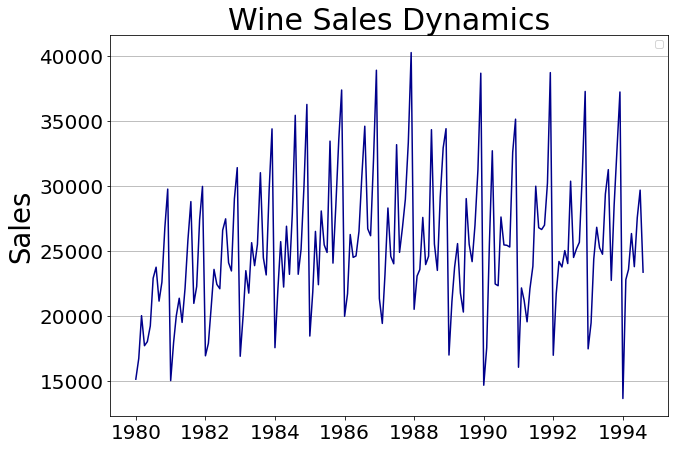

In [ ]:
ts_df.plot(color = 'darkblue', figsize = (10, 7))
plt.grid(axis = 'y')
plt.tick_params(labelsize = 20)
plt.ylabel('Sales', fontsize = 27.5)
plt.xlabel('')
plt.legend('')
plt.title('Wine Sales Dynamics', fontsize = 30)
plt.show()

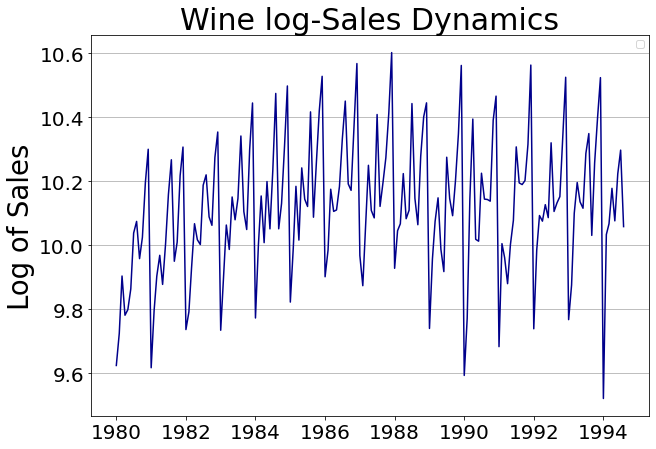

In [ ]:
ts_df.apply(np.log).plot(color = 'darkblue', figsize = (10, 7))
plt.grid(axis = 'y')
plt.tick_params(labelsize = 20)
plt.ylabel('Log of Sales', fontsize = 27.5)
plt.xlabel('')
plt.legend('')
plt.title('Wine log-Sales Dynamics', fontsize = 30)
plt.show()

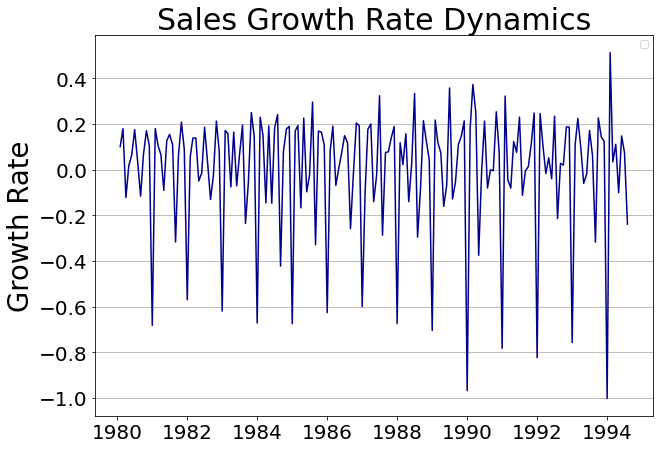

In [ ]:
ts_df.apply(np.log).diff(1).plot(color = 'darkblue', figsize = (10, 7))
plt.grid(axis = 'y')
plt.tick_params(labelsize = 20)
plt.ylabel('Growth Rate', fontsize = 27.5)
plt.xlabel('')
plt.legend('')
plt.title('Sales Growth Rate Dynamics', fontsize = 30)
plt.show()

### Stationarity checking

Как можно заметить, в исходном ряду явно присутствует сезонность, и ряд нестационарный. 

Давайте протестируем его стационарность с помощью теста [Дики-Фуллера](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0) на единичный корень

Вторым параметром на выходе является p-value. Регрессию, используемую в тесте, можно дополнять константой ('c'), константой и трендом ('ct'), использовать без константы и тренда ('nc')

In [ ]:
tsa.adfuller(ts_df['sales'], regression = 'c')

(-2.852467619960656,
 0.05116115205187685,
 11,
 164,
 {'1%': -3.47086589632514, '10%': -2.57625492712671, '5%': -2.879330279087651},
 3004.5684392973585)

Применим к ряду логарифмическое преобразование и посмотрим на стационарность

In [ ]:
tsa.adfuller(ts_df['sales'].apply(np.log), regression = 'c')[1]

0.024994599573228738

Возьмем первую разность логарифма ряда

In [ ]:
tsa.adfuller(ts_df['sales'].apply(np.log).diff(1).dropna(), regression = 'c', maxlag = 3)[1]

5.230309830686484e-28

Тест может отвергнуть нулевую гипотезу о нестационарности

Однако, это не означает, что мы можем сказать, что ряд стационарен. Как Вы помните, в нем присутствовала сезонность, которая также и осталась.

Перед тем, как переходить к моделям временных рядов давайте разберем автокорреляционную функцию (acf) и частную автокорреляционную функцию (pacf).

Нарисовать графики acf и pacf можно через модуль graphics в statsmodels. В нем нужно взять `.tsaplots.plot_acf()` или `.tsaplots.plot_pacf()`

In [ ]:
import statsmodels.graphics as stg

### Autocorrelation function

Автокорреляционная функция показывает корреляцию исходного ряда с его лагами различных порядков. График авктокоррелционной функцией называется коррелограммой. При периодичности у исходного ряда можно наблюдать периодичност у acf.



In [ ]:
acf = tsa.acf(ts_df['sales'].apply(np.log).diff(1).dropna(), nlags = 20, alpha = 0.05)

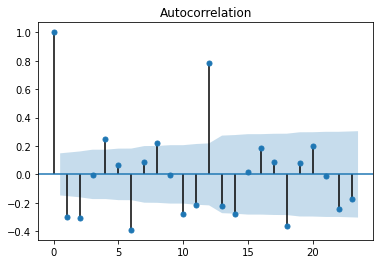

In [ ]:
stg.tsaplots.plot_acf(ts_df['sales'].apply(np.log).diff(1).dropna())
plt.show()

### Partial autocorrelation function

Частная автокорреляционная функция показывает корреляцию между исходным рядом и его лагами, "очищенную" от влияния других лагов. 

К примеру, у Вас есть ряд $\{y_t\}_{t=1}^T$. Вы хотите посмотреть, как изменится $y_4$ при изменении $y_1$. Однако изменение $y_1$ еще как-то повлияет на $y_2$ и $y_3$, которые в свою очередь повлияют на $y_4$. Нам же хотелось бы найти связь, очищенную от промежуточных изменений.

[Формализуя](http://www.machinelearning.ru/wiki/index.php?title=%D0%A7%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0%D1%8F_%D0%B0%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F):

\begin{equation} pacf(k) = \begin{cases} corr(y_t, y_{t-k}), \ k = 1 \\
cor(y_t - P(y_t), y_{t-k} - P(y_{t-k})) \end{cases} \end{equation}

где $P(y_t)$ - проекция $y_t$ на $y_{t-1}, y_{t-2}, ..., y_{t-k+1}$

In [ ]:
pacf = tsa.pacf(ts_df['sales'].apply(np.log).diff(1).dropna(), nlags = 20, alpha = 0.05)

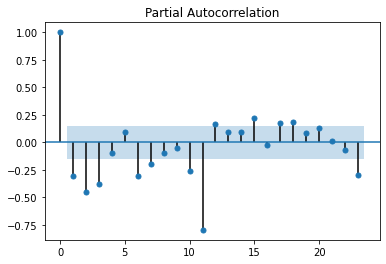

In [ ]:
stg.tsaplots.plot_pacf(ts_df['sales'].apply(np.log).diff(1).dropna())
plt.show()

Также на практике из анализа частной автокорреляционной функции определяют порядок авторегрессионного процесса

### Time Series Models

#### AR(X), MA(X), ARMA(X), ARIMA(X), SARIMA(X)

In [ ]:
ts_reg = tsa.AR(endog = ts_df['sales'].apply(np.log)).fit()
print(ts_reg.summary())

NotImplementedError: ignored

К сожалению, AR и MA процессы по отдельности не реализованы. Однако Вам ничего не мешает использовать модели ARMA и ARIMA, указав нулевые порядки для AR или MA процессов.

ARMA модель определена в методе `ARMA`, которому на вход помимо вашего ряда (аргумент `endog`) требуется подать порядок модели (аргумент `order`) в виде кортежа, где первое число - порядок AR процесса и второе число - порядок MA процесса.

Также в аргумент `exog` можно передать прочие контроли.

In [ ]:
# создадим доп. переменную квадрата логарифма нашего ряда
ts_df['sales_sq'] = ts_df['sales'].apply(np.log) ** 2

In [ ]:
ts_reg = tsa.ARMA(endog = ts_df['sales'].apply(np.log), order = (1, 1)).fit()
print(ts_reg.summary2())

                           Results: ARMA
Model:              ARMA             BIC:                 -39.8765  
Dependent Variable: sales            Log-Likelihood:      30.279    
Date:               2021-04-04 12:45 Scale:               1.0000    
No. Observations:   176              Method:              css-mle   
Df Model:           3                Sample:              01-01-1980
Df Residuals:       173                                   08-01-1994
Converged:          1.0000           S.D. of innovations: 0.204     
No. Iterations:     10.0000          HQIC:                -47.415   
AIC:                -52.5585                                        
---------------------------------------------------------------------
                 Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
---------------------------------------------------------------------
const           10.1197    0.0184  549.2927  0.0000  10.0836  10.1558
ar.L1.sales     -0.2789    0.2290   -1.2177  0.2250  -0.72

Давайте посмотрим, как наша модель обучилась на исходном ряду. Для этого от Вашей модели можно взять метод `.predict()`. В методе аргументами можно добавить Ваши экзогенные переменные с помощью аргумента `exog` (если Вы их использовали), а также начальные и конечные точки прогноза (`start` и `end`, которые можно задать целочисленными индексами, а также датами, если индексация ваших данных происходит по датам)

Также, используя аргумент `dynamic`, Вы можете прогнозировать Ваш ряд, используя предыдущие прогнозные значения (но учитывайте, что на длительном промежутке этот прогноз вряд ли будет хорошим)

Прогноз вперед можно также сделать с помощью метода `.forecast()`, в котором можно аргументами прописать интервал прогноза, уровень значимости и экзогенные переменные (если они использовались)

In [ ]:
k = 12
arma_fit = ts_reg.predict()
arma_forecast = ts_reg.forecast(steps = k, alpha = 0.05)

In [ ]:
arma_fit_mean, arma_forecast_mean = np.exp(arma_fit), np.exp(arma_forecast[0])
arma_forecast_ci_low, arma_forecast_ci_up = np.exp(arma_forecast[2][:, 0]), np.exp(arma_forecast[2][:, 1])

In [ ]:
from dateutil.relativedelta import relativedelta

In [ ]:
arma_forecast_mean = pd.Series(arma_forecast_mean, index = [arma_fit_mean.index[-1] + relativedelta(months = i) for i in range(1, k + 1)])
arma_forecast_ci_low = pd.Series(arma_forecast_ci_low, index = [arma_fit_mean.index[-1] + relativedelta(months = i) for i in range(1, k + 1)])
arma_forecast_ci_up = pd.Series(arma_forecast_ci_up, index = [arma_fit_mean.index[-1] + relativedelta(months = i) for i in range(1, k + 1)])

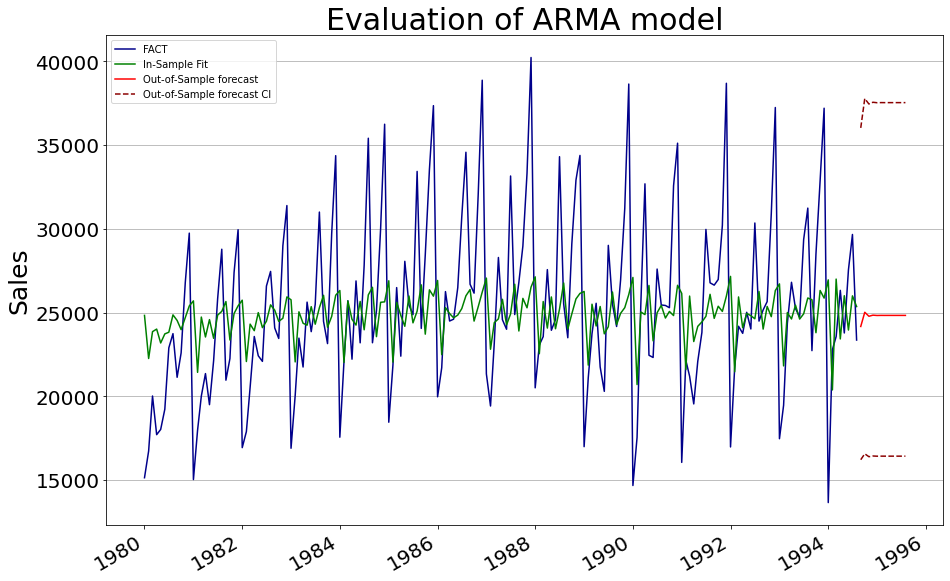

In [ ]:
plt.figure(figsize = (15, 10))
ts_df['sales'].plot(color = 'darkblue', label = 'FACT')
arma_fit_mean.plot(label = 'In-Sample Fit', color = 'g')
arma_forecast_mean.plot(label = 'Out-of-Sample forecast', color = 'r')
arma_forecast_ci_low.plot(label = 'Out-of-Sample forecast CI', color = 'darkred', linestyle = 'dashed')
plt.legend(fontsize = 22)
arma_forecast_ci_up.plot(color = 'darkred', linestyle = 'dashed')
plt.tick_params(labelsize = 20)
plt.xlabel('')
plt.ylabel('Sales', fontsize = 25)
plt.grid(axis = 'y')
plt.title('Evaluation of ARMA model', fontsize = 30)
plt.show()

Также можно добавить еще переменные. В качестве экзогенной переменной мы добавим квадрат логарифма исходного ряда (не совсем экзогенная переменная)

In [ ]:
ts_reg = tsa.ARMA(endog = ts_df['sales'].apply(np.log), exog = ts_df['sales_sq'], order = (1, 1)).fit()
print(ts_reg.summary())

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                  176
Model:                     ARMA(1, 1)   Log Likelihood                 774.360
Method:                       css-mle   S.D. of innovations              0.003
Date:                Sun, 04 Apr 2021   AIC                          -1538.720
Time:                        13:00:56   BIC                          -1522.867
Sample:                    01-01-1980   HQIC                         -1532.290
                         - 08-01-1994                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.0545      0.005    948.288      0.000       5.044       5.065
sales_sq        0.0494   5.19e-05    952.205      0.000       0.049       0.050
ar.L1.sales     0.6053      0.151      3.999    

In [ ]:
arma_fit = ts_reg.predict()
arma_fit = np.exp(arma_fit)

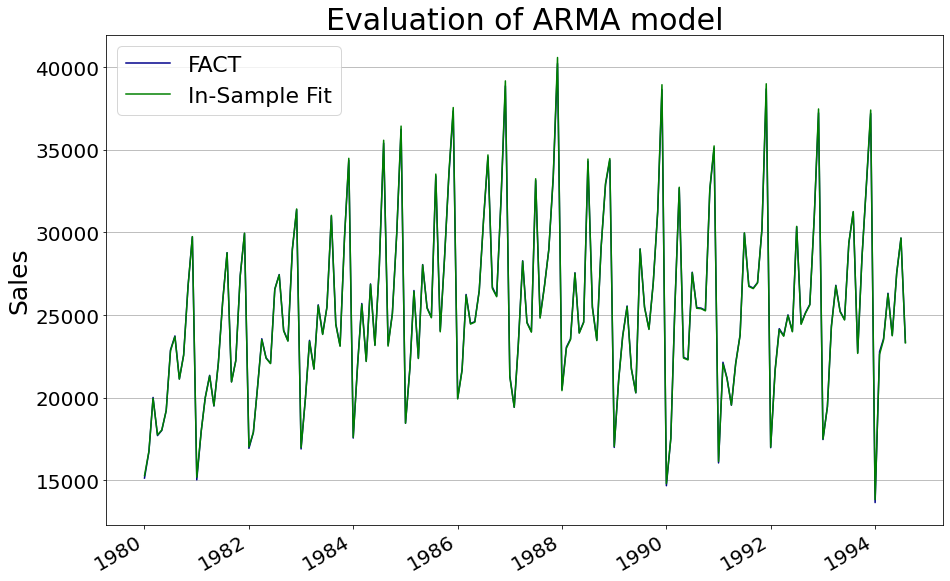

In [ ]:
plt.figure(figsize = (15, 10))
ts_df['sales'].plot(color = 'darkblue', label = 'FACT')
arma_fit.plot(label = 'In-Sample Fit', color = 'g')
plt.legend(fontsize = 22)
plt.tick_params(labelsize = 20)
plt.xlabel('')
plt.ylabel('Sales', fontsize = 25)
plt.grid(axis = 'y')
plt.title('Evaluation of ARMA model', fontsize = 30)
plt.show()

Также реализована в `tsa` и ARIMA модель, которую можно вызвать методом `ARIMA()`, внутри которого также требуется прописать порядок модели. Первое число - порядок AR модели, второе число - порядок дифференциирования ряда, третье число - порядок MA модели.

In [ ]:
ts_reg = tsa.ARIMA(endog = ts_df['sales'].apply(np.log), order = (2, 1, 2)).fit()
print(ts_reg.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                  175
Model:                 ARIMA(2, 1, 2)   Log Likelihood                  35.044
Method:                       css-mle   S.D. of innovations              0.197
Date:                Sun, 04 Apr 2021   AIC                            -58.088
Time:                        13:08:15   BIC                            -39.100
Sample:                    02-01-1980   HQIC                           -50.386
                         - 08-01-1994                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0013      0.001      1.271      0.206      -0.001       0.003
ar.L1.D.sales     0.0967      0.206      0.469      0.639      -0.307       0.500
ar.L2.D.sales    -0.2613      0.079     

In [ ]:
arima_fit = ts_reg.predict()
arima_fit = np.exp(arima_fit + ts_df['sales'].apply(np.log).shift(1))

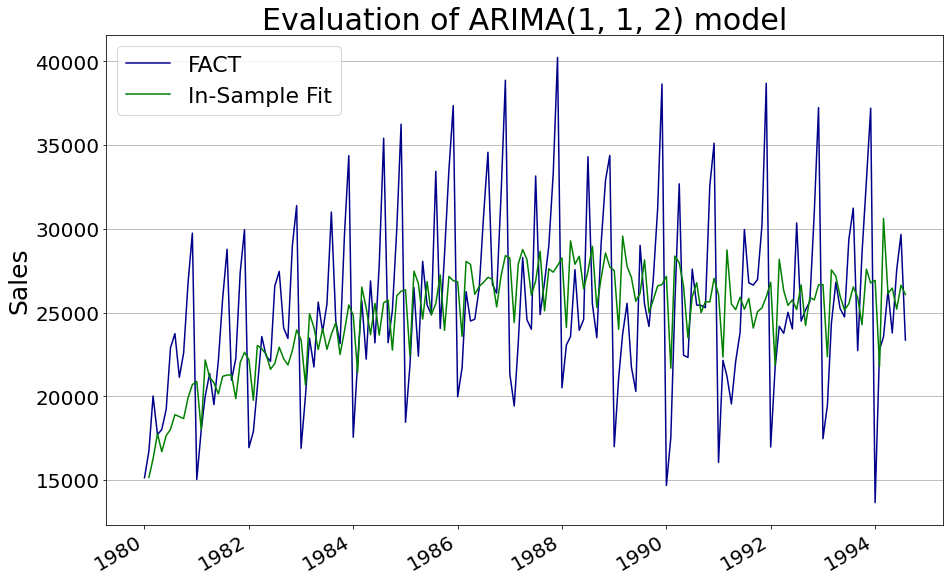

In [ ]:
plt.figure(figsize = (15, 10))
ts_df['sales'].plot(color = 'darkblue', label = 'FACT')
arima_fit.plot(label = 'In-Sample Fit', color = 'g')
plt.legend(fontsize = 22)
plt.tick_params(labelsize = 20)
plt.xlabel('')
plt.ylabel('Sales', fontsize = 25)
plt.grid(axis = 'y')
plt.title('Evaluation of ARIMA(1, 1, 2) model', fontsize = 30)
plt.show()

Также в `tsa` реализована и модель SARIMA(X) в методе `SARIMAX()`, в котором помимо порядка модели ARIMA нужно указать порядок сезонной компоненты - аргумент `seasonal_order`, первое число которого - порядок SAR компоненты, второе число - порядок дифференциирования, третье число - порядок SMA компоненты, и четвертое число - период сезонности (предположим квартальную сезонность)

In [ ]:
ts_reg = tsa.SARIMAX(endog = ts_df['sales'].apply(np.log), order = (1, 1, 1), 
                     seasonal_order = (4, 0, 4, 3)).fit()
print(ts_reg.summary())

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                  176
Model:             SARIMAX(1, 1, 1)x(4, 0, 4, 3)   Log Likelihood                 160.990
Date:                           Sun, 04 Apr 2021   AIC                           -299.980
Time:                                   13:10:45   BIC                           -265.167
Sample:                               01-01-1980   HQIC                          -285.859
                                    - 08-01-1994                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0002      0.096     -0.002      0.998      -0.188       0.188
ma.L1         -0.9442      0.032    -29.510

In [ ]:
sarima_fit = ts_reg.predict()
sarima_fit = np.exp(sarima_fit)

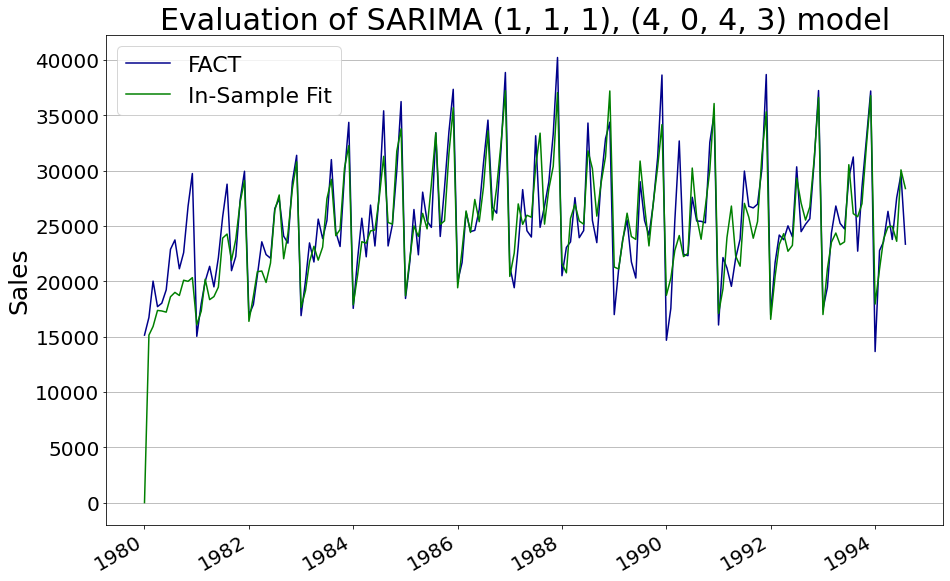

In [ ]:
plt.figure(figsize = (15, 10))
ts_df['sales'].plot(color = 'darkblue', label = 'FACT')
sarima_fit.plot(label = 'In-Sample Fit', color = 'g')
plt.legend(fontsize = 22)
plt.tick_params(labelsize = 20)
plt.xlabel('')
plt.ylabel('Sales', fontsize = 25)
plt.grid(axis = 'y')
plt.title('Evaluation of SARIMA (1, 1, 1), (4, 0, 4, 3) model', fontsize = 30)
plt.show()

Как видим, ряд зафитился довольно неплохо. Первая точка равна нулю, т.к. значение лагов для нее нам нисколько не известно.

#### ARCH/GARCH модели

К сожалению, в statsmodels нет (или нет хорошей) реализации моделей условной гетероскедастичности. Однако есть очень хорошая библиотека [ARCH](https://arch.readthedocs.io/en/latest/index.html), которая содержит в себе целый ряд моделей.

Можно задавтаь как спецификацию процесса условной дисперсии, так и спецификацию модели среднего (constant mean + GARCH, ARIMA-GARCH, и т.д)

In [ ]:
!pip install arch

     |████████████████████████████████| 808kB 5.4MB/s 


In [ ]:
import arch.data.sp500

st = dt(1988, 1, 1)
en = dt(2020, 1, 1)
df = arch.data.sp500.load()
market = df["Adj Close"]
returns = 100 * market.pct_change().dropna()

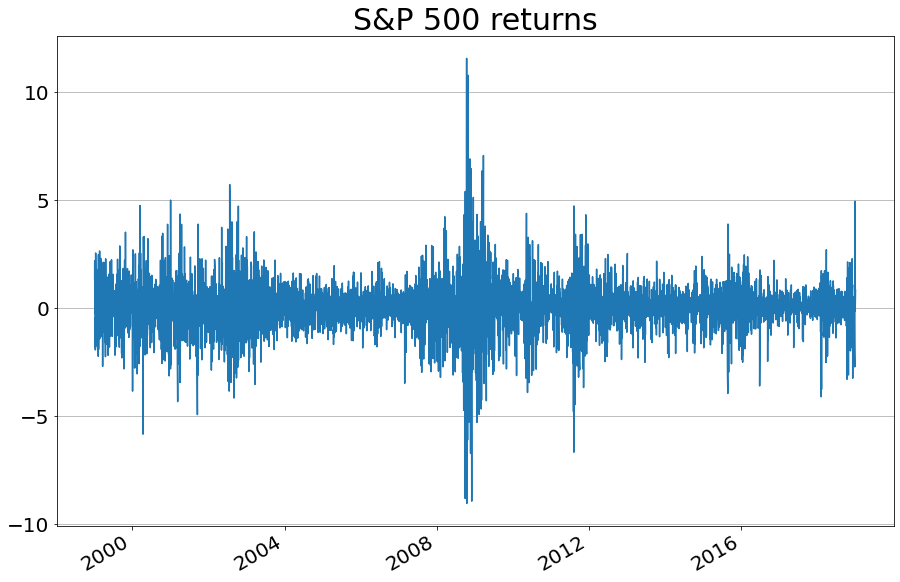

In [ ]:
plt.figure(figsize = (15, 10))
returns.plot()
plt.tick_params(labelsize = 20)
plt.grid(axis = 'y')
plt.title('S&P 500 returns', fontsize = 30)
plt.xlabel('')
plt.show()

In [ ]:
from arch import arch_model

GARCH

Также можно задавтаь распределение инноваций

In [ ]:
garch_student = arch_model(returns, p = 1, q = 1, dist = "StudentsT").fit(disp = "off")
print(garch_student.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6834.74
Distribution:      Standardized Student's t   AIC:                           13679.5
Method:                  Maximum Likelihood   BIC:                           13712.1
                                              No. Observations:                 5030
Date:                      Sun, Apr 04 2021   Df Residuals:                     5029
Time:                              13:41:44   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

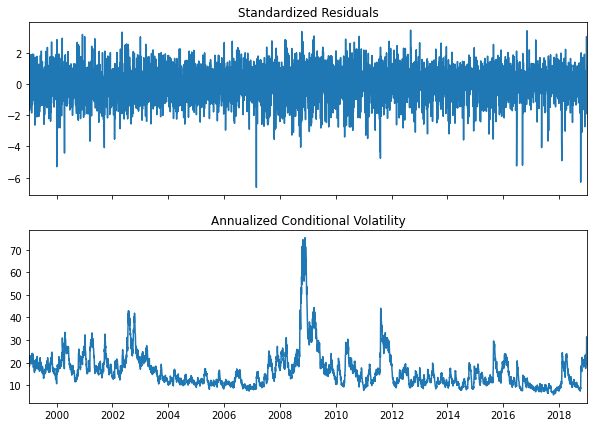

In [ ]:
fig = garch_student.plot(annualize = "D")
fig.set_size_inches((10, 7))

GJR-GARCH

In [ ]:
gjr_garch_student = arch_model(returns, p = 1, o = 1, q = 1, dist = "StudentsT").fit(disp = "off")
print(gjr_garch_student.summary())

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -6744.43
Distribution:      Standardized Student's t   AIC:                           13500.9
Method:                  Maximum Likelihood   BIC:                           13540.0
                                              No. Observations:                 5030
Date:                      Sun, Apr 04 2021   Df Residuals:                     5029
Time:                              13:41:52   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

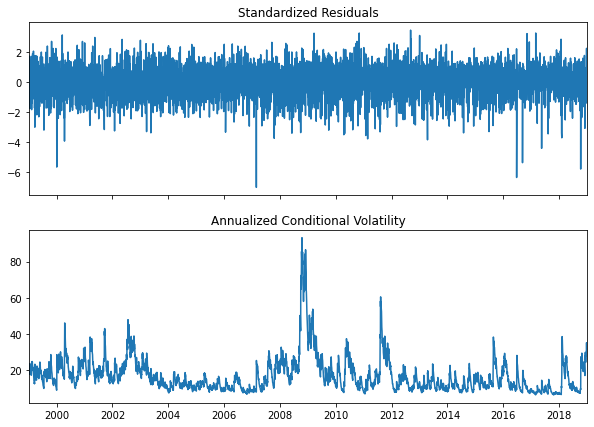

In [ ]:
fig = gjr_garch_student.plot(annualize = "D")
fig.set_size_inches((10, 7))

AR(1)-GJR(1)-GARCH(1,1) with Skewed Student Distribution

In [ ]:
ar_gjr_garch_skewst = arch_model(returns, mean = 'ARX', lags = 1, p = 1, o = 1, q = 1, dist = "skewt").fit(disp = "off")
print(ar_gjr_garch_skewst.summary())

                               AR - GJR-GARCH Model Results                              
Dep. Variable:                         Adj Close   R-squared:                       0.005
Mean Model:                                   AR   Adj. R-squared:                  0.005
Vol Model:                             GJR-GARCH   Log-Likelihood:               -6714.46
Distribution:      Standardized Skew Student's t   AIC:                           13444.9
Method:                       Maximum Likelihood   BIC:                           13497.1
                                                   No. Observations:                 5029
Date:                           Sun, Apr 04 2021   Df Residuals:                     5027
Time:                                   13:46:19   Df Model:                            2
                                   Mean Model                                   
                   coef    std err          t      P>|t|        95.0% Conf. Int.
----------------------------

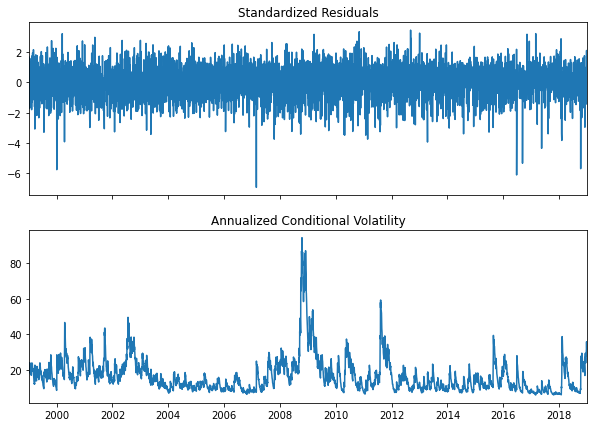

In [ ]:
fig = ar_gjr_garch_skewst.plot(annualize = "D")
fig.set_size_inches((10, 7))

In [ ]:
garch_st_studentized_resid = (garch_student.resid / garch_student.conditional_volatility)
ar_gjr_garch_skewst_studentized_resid = (ar_gjr_garch_skewst.resid / ar_gjr_garch_skewst.conditional_volatility)
gjr_garch_st_studentized_resid = (gjr_garch_student.resid / gjr_garch_student.conditional_volatility)

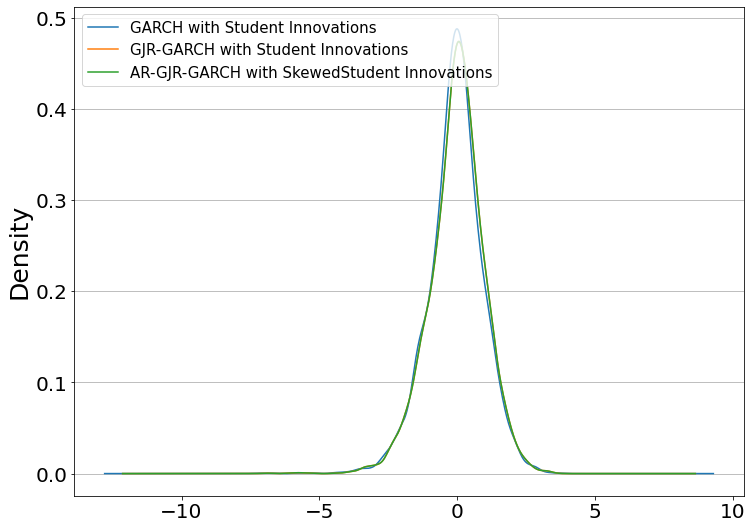

In [ ]:
plt.figure(figsize = (12, 9))
garch_st_studentized_resid.plot(kind = 'kde', label = 'GARCH with Student Innovations')
gjr_garch_st_studentized_resid.plot(kind = 'kde', label = 'GJR-GARCH with Student Innovations')
ar_gjr_garch_skewst_studentized_resid.plot(kind = 'kde', label = 'AR-GJR-GARCH with SkewedStudent Innovations')
plt.grid(axis = 'y')
plt.tick_params(labelsize = 20)
plt.legend(fontsize = 15, loc = 2)
plt.ylabel('Density', fontsize = 25)
plt.show()

## Other models

### Generalized Linear Models (GLM)

Обобщение над линейной регрессией (с помощью рассматриваемого подхода) позволяет рассматривать другие распределения для целевой переменной нежели только Нормальное. Можно предположить, что условное распределение $p(y|x)$ относится к некоторому параметрическому семейству и зависит от некоторого параметра $\theta(X)$, и может быть представлено в следующем виде $p(y|x) = p(y|\theta(x))$

Обобщение происходит через связующую фунцию (link function). Данная функция связывает линейный предиктор, $X\beta$ с целевой переменной y. В случае линейной регрессии эта функция равняется этому же предиктору.

Обобщение полезно, т.к. ряд процессов не подчиняется Нормальному распределению, а рассмотрение обычной линейной регрессии с предпоссылкой о нормальности может давать неадекватные результаты. Например, если наш процесс представляет из себя ряд посчитанных значений (счетчик), то стандартная линейная регрессия может давать прогнозы, выходящие за область определения целевой переменной. Вдобавок, в линейной регрессии постоянные изменения в объясняющих переменных дают постоянные изменения в целевой переменной, что далеко не всегда верно (может быть зависимость экспоненциальна?)

Остается найти такое $\theta(x)$, которое отвечало бы нашим представлениям о распределении целевой переменной. Мы будем предполагать, что распределение $p(y|\theta(x))$ (в дальнейшем вместо $\theta(x) = \theta$) принадлежит экспоненциальному семейству распределений и может быть представлено в следующем виде:

\begin{equation} p(y|\eta(x)) = \frac{h(y)}{Z(\eta(x))} exp(<\eta(x), s(y)>) \end{equation}

где $h(y), s(y)$ - какие-то функции от целевой переменной, $\eta(x) = \phi(\theta(x))$, и $Z(\eta(x))$ - нормировочная константа.

Осталось найти функцию, связывающую натуральные и классические параметры распределения: $\eta(x) = \phi(\theta(x))$, $\phi(..)$ - функция связи.

**Пример. Модель с целевой переменной, распределенной по Пуассону**

$p(y|\theta) = e^{-\theta} \frac{\theta^y}{y!}= e^{-\theta} \frac{e^{y\log{\theta}}}{y!} = \frac{1}{y!} \frac{1}{e^\theta} exp(y\log{\theta})$

Где $h(y) = \frac{1}{y!}$, $s(y) = y$, $\eta(x) = \log{\theta(x)}$, и $\theta(x) = exp(\eta(x))$

Запишем правдоподобие:

\begin{equation} l(w, X) = \sum_{i=1}^l (\log{\frac{1}{y!}} - e^{\eta(x_i)} + y_i\eta(x_i) = \sum_{i=1}^l (-exp(<w,x_i>) + y_i<w, x_i> \end{equation}

Максимизация производится градиентными методами.

В Python GLM можно найти например в библиотеке statsmodels.api и также в statsmodels.formula.api

In [ ]:
df = pd.read_csv('/content/nyc-east-river-bicycle-counts.csv')

df.head()

,Unnamed: 0,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,0,2016-04-01 00:00:00,2016-04-01 00:00:00,78.1,66.0,0.01,1704.0,3126,4115.0,2552.0,11497
1,1,2016-04-02 00:00:00,2016-04-02 00:00:00,55.0,48.9,0.15,827.0,1646,2565.0,1884.0,6922
2,2,2016-04-03 00:00:00,2016-04-03 00:00:00,39.9,34.0,0.09,526.0,1232,1695.0,1306.0,4759
3,3,2016-04-04 00:00:00,2016-04-04 00:00:00,44.1,33.1,0.47 (S),521.0,1067,1440.0,1307.0,4335
4,4,2016-04-05 00:00:00,2016-04-05 00:00:00,42.1,26.1,0,1416.0,2617,3081.0,2357.0,9471


In [ ]:
df.rename(columns = {'Low Temp (°F)': 'LowTemp', 'High Temp (°F)': 'HighTemp', 
                     'Brooklyn Bridge': 'Brooklyn_Bridge', 'Manhattan Bridge': 'Manhattan_Bridge'}, inplace = True)

Давайте опробуем регрессию Пуассона

In [ ]:
specification = 'Total ~ LowTemp + Brooklyn_Bridge'

pois_reg = smf.glm(specification, df, family = sm.families.Poisson()).fit()
print(pois_reg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                  210
Model:                            GLM   Df Residuals:                      207
Model Family:                 Poisson   Df Model:                            2
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15283.
Date:                Sun, 04 Apr 2021   Deviance:                       28188.
Time:                        14:08:36   Pearson chi2:                 2.71e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.4597      0.003   25

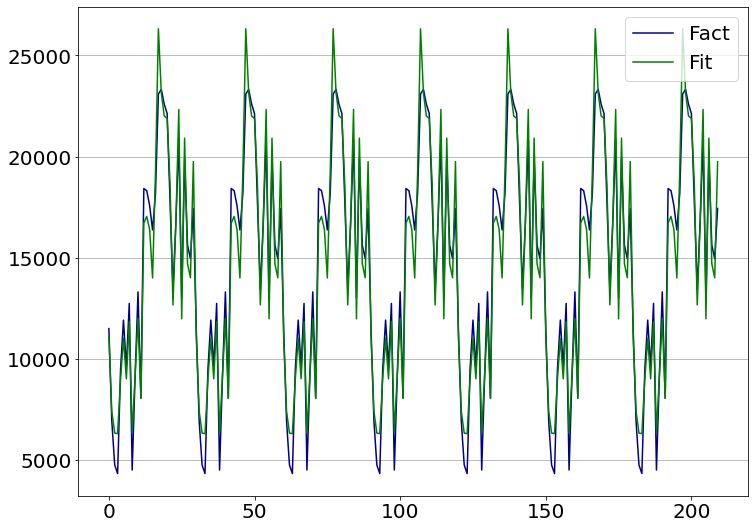

In [ ]:
mean_pred = pois_reg.get_prediction()

plt.figure(figsize = (12, 9))
plt.plot(df['Total'].values, label = 'Fact', color = 'darkblue')
plt.plot(mean_pred.predicted_mean, label = 'Fit', color = 'g')
plt.grid(axis = 'y')
plt.tick_params(labelsize = 20)
plt.legend(fontsize = 20)
plt.show()

### Quantile Regression

Квантильная регрессия также реализована в пакете statsmodels. В методе `.fit()` требуется указать квантиль через аргумент `q`, где $q \in [0, 1]$

In [ ]:
specification = 'Total ~ LowTemp + Brooklyn_Bridge'

quantile_reg_25 = smf.quantreg(specification, df).fit(q = 0.25)
quantile_reg_50 = smf.quantreg(specification, df).fit(q = 0.5)
quantile_reg_75 = smf.quantreg(specification, df).fit(q = 0.75)
print(quantile_reg_50.summary())

                         QuantReg Regression Results                          
Dep. Variable:                  Total   Pseudo R-squared:               0.8826
Model:                       QuantReg   Bandwidth:                       432.8
Method:                 Least Squares   Sparsity:                        1290.
Date:                Sun, 04 Apr 2021   No. Observations:                  210
Time:                        14:14:09   Df Residuals:                      207
                                        Df Model:                            2
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1419.7168    222.029      6.394      0.000     981.989    1857.445
LowTemp            14.4750      5.292      2.735      0.007       4.042      24.908
Brooklyn_Bridge     5.4128      0.051    105.394      0.000       5.312       5.514

The condition number is la

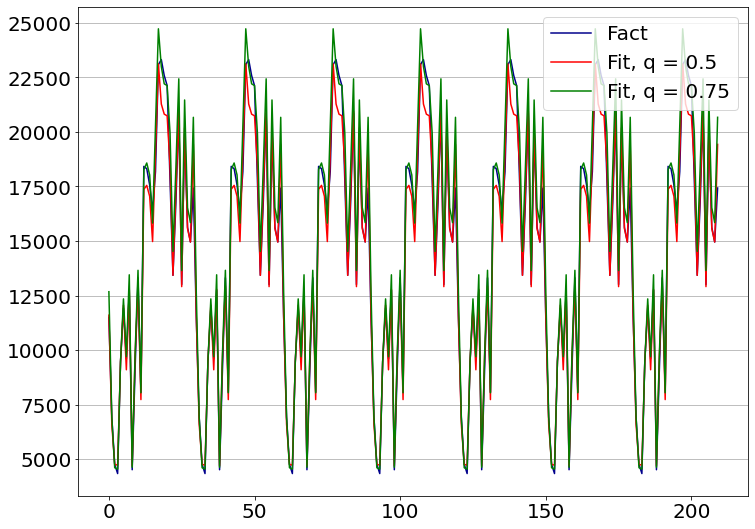

In [ ]:
plt.figure(figsize = (12, 9))
plt.plot(df['Total'].values, label = 'Fact', color = 'darkblue')
#plt.plot(quantile_reg_25.predict(), label = 'Fit, q = 0.25', color = 'orange')
plt.plot(quantile_reg_50.predict(), label = 'Fit, q = 0.5', color = 'r')
plt.plot(quantile_reg_75.predict(), label = 'Fit, q = 0.75', color = 'g')
plt.grid(axis = 'y')
plt.tick_params(labelsize = 20)
plt.legend(fontsize = 20)
plt.show()

Бывает полезным с помощью квантильной регрессии прогнозировать отдельные квантили распределения. Можно получить что-то наподобие прогнозного интервала.

### Kernel Regression

In [ ]:
from statsmodels.nonparametric.kernel_regression import KernelReg

In [ ]:
endog = df['Total'] 
exog = df['Brooklyn_Bridge']

kernel_reg = KernelReg(exog = exog, endog = endog, bw = 'cv_ls', reg_type = 'lc', var_type = 'c')

In [ ]:
kernel_reg_pred = kernel_reg.fit()[0]

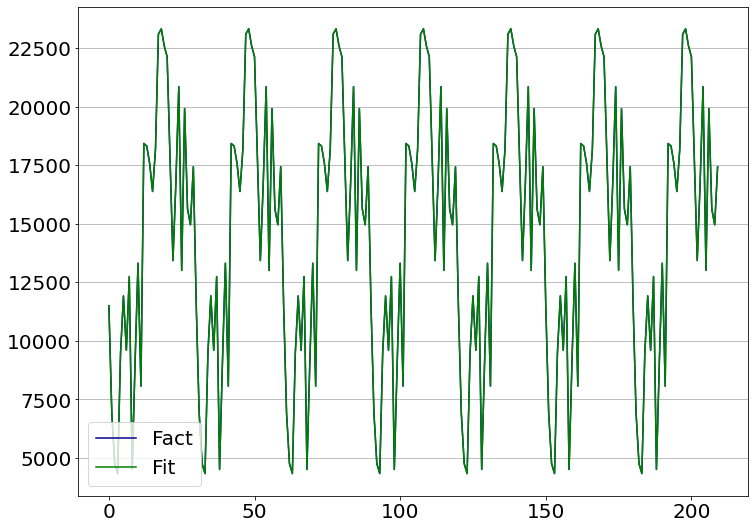

In [ ]:
plt.figure(figsize = (12, 9))
plt.plot(df['Total'].values, label = 'Fact', color = 'darkblue')
plt.plot(kernel_reg_pred, label = 'Fit', color = 'g')
plt.grid(axis = 'y')
plt.tick_params(labelsize = 20)
plt.legend(fontsize = 20)
plt.show()